In [1]:
from jupyter_imports import *
import copy

In [2]:
original_pnl = pd.read_csv(os.path.join(os.sep, 'tmp','pfoptimizer','pnl.csv'), 
                           date_parser=parser.parse, 
                           parse_dates=['end_time'],
                           index_col=0)
original_trajectory = pd.read_csv(os.path.join(os.sep, 'tmp','pfoptimizer','trajectory.csv'))
equity = 1e7

In [3]:
end = datetime.now().replace(tzinfo=timezone.utc)
start = end - timedelta(days = 365)
pnl = original_pnl[(original_pnl['end_time']>start)&(original_pnl['end_time']<end)]
pnl['amtUSD'] *= 1e4/equity # all in bps
# correct error(temporary !)
pnl.loc[pnl['bucket']=='carry(USD not annualized)','amtUSD'] = pnl.loc[pnl['bucket']=='carry(USD not annualized)','amtUSD'] / 8.

carry = pnl[pnl['bucket']=='carry(USD not annualized)'].drop(columns='bucket')
weights = pnl[pnl['bucket']=='weights'].drop(columns='bucket')
IR01 = pnl[pnl['bucket']=='IR01(USD)'].drop(columns='bucket')

# Excess return in bps
## assumes spreads are done at mid every funding period
## Pls note there is no hyperparamters (so no overfit here)
### * carry = funding-borrow
### * IR01 = spot*premium chg
### * delta = 0 (only exists during exec)

In [4]:
pnl[(pnl['name']=='total')&(pnl['bucket']!='weights')].pivot_table(index='end_time',columns='bucket',values='amtUSD').cumsum().iplot()

In [5]:
pnl.pivot_table(index='end_time',columns='bucket',values='amtUSD').iplot(secondary_y='weights')

## weights

In [6]:
carry.pivot_table(index='end_time', columns='name').xs('amtUSD', axis=1).cumsum().iplot(secondary_y=['USDT', 'total'])

leverage = 2.074519027320961


avg_weight_pct  avg_funding_pct
name                                      
XRPUSDT         10.106261        51.710132
ETHUSDT         10.087790        46.468732
DOGEUSDT         9.682468        50.031872
ARBUSDT          9.090593        59.294656
AVAXUSDT         7.420775        49.298340
BTCUSDT          7.380851        44.459149
MATICUSDT        6.984959        50.252539
LINKUSDT         6.741401        47.087133
OPUSDT           6.684522        60.165145
NEARUSDT         6.492154        54.957157
ADAUSDT          6.438801        46.244693
FILUSDT          6.418705        57.393112
WLDUSDT          6.016353        47.296320
RUNEUSDT         5.985660        47.775398
FETUSDT          5.834761        66.284666
LTCUSDT          5.306080        50.843743
SUIUSDT          5.251602        48.876209
RNDRUSDT         5.004490        56.868622
SEIUSDT          5.000859        51.847540
FTMUSDT          4.712999        49.860214

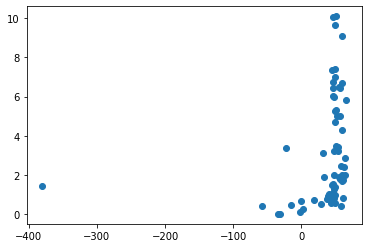

In [7]:
avg_weights = weights.pivot_table(index='end_time', columns='name').mean().xs('amtUSD').drop(['total', 'USDT'])/1e4
print(f'leverage = {avg_weights.sum()}')
funding = original_trajectory.pivot_table(index='time', columns='name', values='funding')
averages = pd.DataFrame({'avg_weight_pct': avg_weights*100,
            'avg_funding_pct': funding.mean()*100}).sort_values('avg_weight_pct', key=abs, ascending=False)
plt.scatter(x=averages['avg_funding_pct'], y=averages['avg_weight_pct'])
averages.head(20)

# tracking error

In [23]:
df = copy.deepcopy(original_trajectory)
df = df.loc[df['name']=='total', ['time', 'RealizedCarry', 'ExpectedCarry', 'transactionCost']].set_index('time')
# df['tracking_error'] = (df['RealizedCarry']-df['ExpectedCarry'])
df = df.cumsum() / 3/365.25 / equity
df.iplot()
df.mean()

RealizedCarry      0.135377
ExpectedCarry      0.254256
transactionCost    0.000117
dtype: float64

# benchmarks

In [13]:
df = copy.deepcopy(original_trajectory)
df = df[df['name']!='USDT']
df['RealizedCarry'] /= equity
df['carry'] = df.apply(lambda x: max(-x['funding']-x['borrow'],x['funding']), axis=1)
df['carry'] = df['funding']
pivot = df.pivot_table(index='time', columns='name')
benchmarks = pd.concat([pivot.xs(['carry'], axis=1), pivot[[('RealizedCarry', 'total')]]], axis=1).droplevel(0, axis=1)
stats = pd.DataFrame()
stats['vs mean'] = (benchmarks['total']-benchmarks.drop(columns='total').mean(axis=1))
stats['vs median'] = (benchmarks['total']-benchmarks.drop(columns='total').median(axis=1))
stats['vs 1sigma'] = stats['vs mean']-benchmarks.drop(columns='total').std(axis=1)
stats['vs BTC'] = (benchmarks['total']-benchmarks['BTCUSDT'])
stats['vs ETH'] = (benchmarks['total']-benchmarks['ETHUSDT'])
stats['vs ARB'] = (benchmarks['total']-benchmarks['ARBUSDT'])
stats.expanding().mean().iplot()

/tmp/ipykernel_2717079/943300803.py:7: FutureWarning:

Passing lists as key for xs is deprecated and will be removed in a future version. Pass key as a tuple instead.

